In [9]:
#Install all the Reqiuired Libraries and Packages
import os
import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc , logfbank
import librosa as lr
import os, glob, pickle
import librosa
from scipy import signal
import noisereduce as nr
from glob import glob
import librosa
get_ipython().magic('matplotlib inline')
#All the Required Packages and Libraies are installed.
import soundfile
from tensorflow.keras.layers import Conv2D,MaxPool2D, Flatten, LSTM
from keras.layers import Dropout,Dense,TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

/var/folders/5y/332j26ls5r9bxfxv0h0yz8xc0000gn/T/ipykernel_3495/3461236087.py:17: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('matplotlib inline')


ModuleNotFoundError: No module named 'tensorflow'

In [3]:
pip install noisereduce

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.4/156.4 kB 13.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install python_speech_features

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=b676a01b1c3b8ed897529e3c195ac71266c901150fc5113976c81287d96f41fc
  Stored in directory: /Users/nithyareddybilla/Library/Caches/pip/wheels/60/90/3c/4b5996a95d363fa14525597a19146a940bec467b44b2a14580
Successfully built python_speech_features
Note: you may need to restart the kernel to use updated packages.


In [11]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [13]:
#Loading the required RAVDESS DataSet with length of 1439 Audio Files
os.listdir(path='/content/drive/MyDrive/Speech_Emotion_Detection-master/speech-emotion-recognition-ravdess-data')
def getListOfFiles(dirName):
    listOfFile=os.listdir(dirName)
    allFiles=list()
    for entry in listOfFile:
        fullPath=os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles=allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

dirName = '/content/drive/MyDrive/Speech_Emotion_Detection-master/speech-emotion-recognition-ravdess-data/'
listOfFiles = getListOfFiles(dirName)
len(listOfFiles)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Speech_Emotion_Detection-master/speech-emotion-recognition-ravdess-data'

In [15]:
pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 30.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
#Use the Speech-Recognition API to get the Raw Text from Audio Files, Though Speech Recognition
#is less strong for large chunk of files , so used Error Handling , where when it is not be able to
#produce the text of a particular Audio File it prints the statement 'error'.Just for understanding Audio
import speech_recognition as sr
r=sr.Recognizer()
for file in range(0 , len(listOfFiles) , 1):
    with sr.AudioFile(listOfFiles[file]) as source:
        audio = r.listen(source)
        try:
            text = r.recognize_google(audio)
            print(text)
        except:
            print('error')

NameError: name 'listOfFiles' is not defined

In [19]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [21]:
#Plotting the Basic Graphs for understanding of Audio Files :
for file in range(0 , len(listOfFiles) , 1):
    audio , sfreq = lr.load(listOfFiles[file])
    time = np.arange(0 , len(audio)) / sfreq

    fig ,ax = plt.subplots()
    ax.plot(time , audio)
    ax.set(xlabel = 'Time (s)' , ylabel = 'Sound Amplitude')
    plt.show()

#PLOT THE SEPCTOGRAM
for file in range(0 , len(listOfFiles) , 1):
     sample_rate , samples = wavfile.read(listOfFiles[file])
     frequencies , times, spectrogram = signal.spectrogram(samples, sample_rate)
     plt.pcolormesh(times, frequencies, spectrogram)
     plt.imshow(spectrogram)
     plt.ylabel('Frequency [Hz]')
     plt.xlabel('Time [sec]')
     plt.show()

NameError: name 'listOfFiles' is not defined

In [23]:
#Next Step is In-Depth Visualisation of Audio Fiels and its certain features to plot for.
#They are the Plotting Functions to be called later.
def plot_signals(signals):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Time Series' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_fft(fft):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Fourier Transform' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            data = list(fft.values())[i]
            Y,freq = data[0] , data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq , Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_fbank(fbank):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Filter Bank Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def plot_mfccs(mfccs):
    fig , axes = plt.subplots(nrows=2, ncols=5,sharex =False , sharey=True, figsize=(20,5))
    fig.suptitle('Mel Frequency Capstrum  Coefficients' , size=16)
    i=0
    for x in range(2):
        for y in range(5):
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],
                             cmap='hot', interpolation = 'nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i +=1

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n , d= 1/rate)
    Y= abs(np.fft.rfft(y)/n)
    return(Y,freq)

In [ ]:
# Here The Data Set is loaded and plots are Visualised by Calling the Plotting Functions .
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
for file in range(0 , len(listOfFiles) , 1):
    rate, data = wav.read(listOfFiles[file])
    fft_out = fft(data)
    %matplotlib inline
    plt.plot(data, np.abs(fft_out))
    plt.show()

signals={}
fft={}
fbank={}
mfccs={}
# load data
for file in range(0 , len(listOfFiles) , 1):
#     rate, data = wavfile.read(listOfFiles[file])
     signal,rate =librosa.load(listOfFiles[file] , sr=44100)
     mask = envelope(signal , rate , 0.0005)
     signals[file] = signal
     fft[file] = calc_fft(signal , rate)

     bank = logfbank(signal[:rate] , rate , nfilt = 26, nfft = 1103).T
     fbank[file] = bank
     mel = mfcc(signal[:rate] , rate , numcep =13 , nfilt = 26 , nfft=1103).T
     mfccs[file]=mel

plot_signals(signals)
plt.show()

plot_fft(fft)
plt.show()

plot_fbank(fbank)
plt.show()

plot_mfccs(mfccs)
plt.show()

In [ ]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOICES AROUND THE MAIN AUDIO VOICE
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [ ]:
#The clean Audio Files are redirected to Clean Audio Folder Directory
import glob,pickle
for file in tqdm(glob.glob('/content/drive/MyDrive/Speech_Emotion_Detection-master/speech-emotion-recognition-ravdess-data//**//*.wav')):
    file_name = os.path.basename(file)
    signal , rate = librosa.load(file, sr=16000)
    mask = envelope(signal,rate, 0.0005)
    wavfile.write(filename= '/content/drive/MyDrive/Speech_Emotion_Detection-master/clean_speech/'+str(file_name), rate=rate,data=signal[mask])

100%|██████████| 1439/1439 [15:49<00:00,  1.52it/s]


In [ ]:
#Feature Extraction of Audio Files Function
#Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
    X, sample_rate = lr.load(file_name)
    result = np.array([])
    if mfcc:
        mfccs = np.mean(lr.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(lr.feature.chroma_stft(S=lr.feature.melspectrogram(y=X, sr=sample_rate)).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(lr.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))
    return result


In [ ]:
#Emotions in the RAVDESS dataset to be classified Audio Files based on .
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
#These are the emotions User wants to observe more :
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [ ]:

#Load the data and extract features for each sound file
from glob import glob
import os
import glob
def load_data(test_size=0.33):
    x,y=[],[]
    answer = 0
    for file in glob.glob('/content/drive/MyDrive/Speech_Emotion_Detection-master/clean_speech//*.wav'):
        file_name=os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]  # Use index 0 instead of 1


        if emotion not in observed_emotions:
            answer += 1
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append([emotion,file_name])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
#Split the dataset
import librosa
import numpy as np
x_train,x_test,y_trai,y_tes=load_data(test_size=0.25)
print(np.shape(x_train),np.shape(x_test), np.shape(y_trai),np.shape(y_tes))
y_test_map = np.array(y_tes).T
y_test = y_test_map[0]
test_filename = y_test_map[1]
y_train_map = np.array(y_trai).T
y_train = y_train_map[0]
train_filename = y_train_map[1]
print(np.shape(y_train),np.shape(y_test))
print(*test_filename,sep="\n")

In [ ]:

# Initialize the Multi Layer Perceptron Classifier
model_mlp=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
#Train the model
model_mlp.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [ ]:
#The file 'output10.wav' in the next cell is the file that was recorded live using the code :
data, sampling_rate = librosa.load('/content/drive/MyDrive/Speech_Emotion_Detection-master/output102.wav')
%matplotlib inline
import os
import pandas as pd
import librosa.display
import glob

plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [ ]:
#Now Cleaning Step is Performed where:
#DOWN SAMPLING OF AUDIO FILES IS DONE  AND PUT MASK OVER IT AND DIRECT INTO CLEAN FOLDER
#MASK IS TO REMOVE UNNECESSARY EMPTY VOIVES AROUND THE MAIN AUDIO VOICE
def envelope(y , rate, threshold):
    mask=[]
    y=pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/10) ,  min_periods=1 , center = True).mean()
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [ ]:
#The clean Audio Files are redirected to Clean Audio Folder Directory
import glob,pickle
file = '/content/drive/MyDrive/Speech_Emotion_Detection-master/output102.wav'
file_name = os.path.basename(file)
signal , rate = librosa.load(file, sr=16000)
mask = envelope(signal,rate, 0.0005)
wavfile.write(filename= r'C:\Users\shiny\Documents\Speech_Emotion_Detection-master\clean_speech1\\'+str(file_name), rate=rate,data=signal[mask])

In [ ]:
## Appying extract_feature function on random file and then loading model to predict the result
file = '/content/drive/MyDrive/Speech_Emotion_Detection-master/output102.wav'
# data , sr = librosa.load(file)
# data = np.array(data)
ans =[]
new_feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
ans.append(new_feature)
ans = np.array(ans)
# data.shape

Emotion_Voice_Detection_Model.predict(ans)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss

# Create an instance of MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=100)

# Train the model
mlp.fit(x_train, y_train)

# Make predictions on the test set
y_pred = mlp.predict(x_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate loss (cross-entropy loss)
loss = log_loss(y_test, mlp.predict_proba(x_test))
print("Loss:", loss)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='weighted', labels=observed_emotions)
recall = recall_score(y_test, y_pred, average='weighted', labels=observed_emotions)
f1 = f1_score(y_test, y_pred, average='weighted', labels=observed_emotions)

# Print the metrics
print("Metrics of MLPClassifier")
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Metrics of MLPClassifier
Accuracy: 0.65625
Precision: 0.6737711180303293
Recall: 0.65625
F1 Score: 0.658151936846361


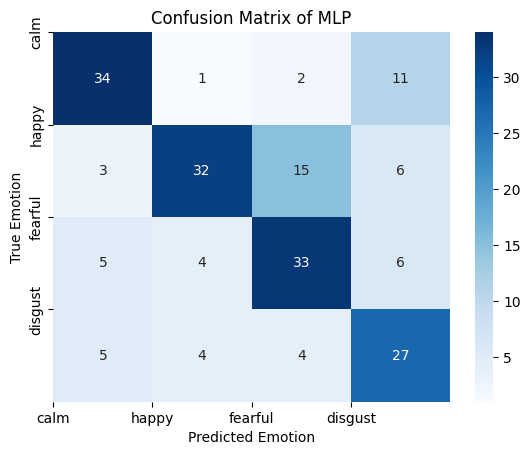

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm_mlp = confusion_matrix(y_test, y_pred, labels=observed_emotions)

# Define labels for the confusion matrix
labels = observed_emotions

# Create a heatmap for the confusion matrix
sns.heatmap(cm_mlp, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)

# Add labels, title, and axis ticks
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('Confusion Matrix of MLP')
plt.xticks(ticks=np.arange(len(labels)), labels=labels)
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

# Display the confusion matrix
plt.show()



In [ ]:
pip install praat-parselmouth


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 98.8 MB/s eta 0:00:00


In [ ]:
import parselmouth

def extract_pitch(audio_file):
    snd = parselmouth.Sound(audio_file)
    pitch = snd.to_pitch()
    pitch_values = pitch.selected_array['frequency']
    average_pitch = pitch_values.mean()
    pitch_range = pitch_values.max() - pitch_values.min()
    return average_pitch, pitch_range

def extract_intensity(audio_file):
    snd = parselmouth.Sound(audio_file)
    intensity = snd.to_intensity()
    average_intensity = intensity.values.mean()
    intensity_range = intensity.values.max() - intensity.values.min()
    return average_intensity, intensity_range

def extract_duration(audio_file):
    snd = parselmouth.Sound(audio_file)
    total_duration = snd.get_total_duration()
    return total_duration

# Example usage
audio_file = '/content/drive/MyDrive/Speech_Emotion_Detection-master/output103.wav'
average_pitch, pitch_range = extract_pitch(audio_file)
average_intensity, intensity_range = extract_intensity(audio_file)
total_duration = extract_duration(audio_file)

print("Average Pitch:", average_pitch)
print("Pitch Range:", pitch_range)
print("Average Intensity:", average_intensity)
print("Intensity Range:", intensity_range)
print("Total Duration:", total_duration)


Average Pitch: 205.93804300488426
Pitch Range: 483.2884430612861
Average Intensity: 54.601230414072624
Intensity Range: 48.656858207442625
Total Duration: 2.0893749487998687


In [ ]:
import librosa

def extract_mfcc(audio_file):
    y, sr = librosa.load(audio_file)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    return mfcc

def extract_chroma(audio_file):
    y, sr = librosa.load(audio_file)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return chroma

def extract_mel(audio_file):
    y, sr = librosa.load(audio_file)
    mel = librosa.feature.melspectrogram(y=y, sr=sr)
    return mel

# Example usage
audio_file = '/content/drive/MyDrive/Speech_Emotion_Detection-master/output103.wav'
mfcc = extract_mfcc(audio_file)
chroma = extract_chroma(audio_file)
mel = extract_mel(audio_file)

print("MFCC shape:", mfcc.shape)
print("Chroma shape:", chroma.shape)
print("Mel shape:", mel.shape)


MFCC shape: (20, 90)
Chroma shape: (12, 90)
Mel shape: (128, 90)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Initialize the SVM classifier
svm_model = SVC(kernel='rbf')

# Train the model
svm_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred_mlp = svm_model.predict(x_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_mlp)
print("Accuracy:", accuracy)


Accuracy: 0.5677083333333334


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_mlp)

# Calculate precision
precision = precision_score(y_test, y_pred_mlp, average='weighted')

# Calculate recall
recall = recall_score(y_test, y_pred_mlp, average='weighted')

# Calculate F1-score
f1 = f1_score(y_test, y_pred_mlp, average='weighted')

# Print the results
print("Metrics of SVM")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Metrics of SVM
Accuracy: 0.5677083333333334
Precision: 0.5926170738200813
Recall: 0.5677083333333334
F1-score: 0.5546429003808938


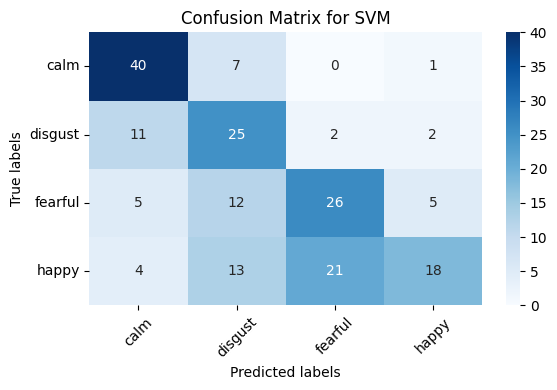

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)

# Get the class labels
class_labels = sorted(set(y_test))

# Create a figure and axes
plt.figure(figsize=(6,4))
ax = plt.subplot()

# Create the confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)

# Set labels, title, and ticks
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("Confusion Matrix for SVM")
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

# Rotate tick labels for better readability
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 15.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder
import librosa

# Path to the RAVDESS dataset
dataset_path = "/content/drive/MyDrive/Speech_Emotion_Detection-master/speech-emotion-recognition-ravdess-data"

# List of emotions in the RAVDESS dataset
emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Function to extract features from audio files
def extract_features(file_path):
    audio, _ = librosa.load(file_path, duration=2.5, offset=0.5)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
    return mfccs.T

# Load audio files and extract features
X = []
y = []
lengths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion = emotions[file.split("-")[2]]
            features = extract_features(file_path)
            X.append(features)
            y.append(emotion)
            lengths.append(features.shape[0])

# Convert the data to numpy arrays
X = np.concatenate(X)
y = np.array(y)

# Encode emotion labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

def create_HMM_model(X, y, n_components):
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag")
    model.fit(X, lengths)  # Fit the model
    return model

# Create an HMM model
model = create_HMM_model(X, y_encoded, n_components=len(emotions))

# Predict the hidden states for a new input
new_features = extract_features("/content/drive/MyDrive/Speech_Emotion_Detection-master/output102.wav")
predicted_states = model.predict(new_features)

# Map the predicted states back to emotion labels
predicted_emotions = label_encoder.inverse_transform(predicted_states)

# Print the predicted emotions
print("Predicted emotions:", predicted_emotions)


Predicted emotions: ['calm' 'calm' 'calm' 'calm' 'calm' 'fearful' 'fearful' 'fearful'
 'fearful' 'fearful' 'fearful' 'fearful' 'fearful' 'fearful' 'fearful'
 'fearful' 'fearful' 'fearful' 'fearful' 'neutral' 'surprised' 'neutral'
 'surprised' 'sad' 'sad' 'sad' 'sad' 'sad' 'sad' 'sad' 'surprised' 'angry'
 'angry' 'angry' 'angry' 'angry' 'angry' 'angry' 'angry' 'angry' 'fearful'
 'fearful' 'fearful' 'fearful' 'fearful' 'fearful' 'fearful' 'fearful'
 'fearful' 'angry' 'angry' 'angry' 'angry' 'angry' 'angry' 'angry' 'angry'
 'angry' 'angry' 'neutral' 'surprised' 'neutral' 'surprised' 'sad' 'sad'
 'sad']


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert the ground truth labels to integers
y_true_encoded = label_encoder.transform(y)

# Pad the predicted states to match the length of y_true_encoded
if len(predicted_states) < len(y_true_encoded):
    padding = np.zeros(len(y_true_encoded) - len(predicted_states), dtype=int)
    predicted_states = np.concatenate([predicted_states, padding])

# Trim y_true_encoded to match the length of predicted_states
if len(y_true_encoded) > len(predicted_states):
    y_true_encoded = y_true_encoded[:len(predicted_states)]

# Calculate accuracy
accuracy = accuracy_score(y_true_encoded, predicted_states)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true_encoded, predicted_states, average='weighted')
recall = recall_score(y_true_encoded, predicted_states, average='weighted')
f1 = f1_score(y_true_encoded, predicted_states, average='weighted')



# Print the metrics
print("Metrics of HMM")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:")



Metrics of HMM
Accuracy: 0.13273106323835998
Precision: 0.048670313904896054
Recall: 0.13273106323835998
F1-Score: 0.036547924230178566
Confusion Matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


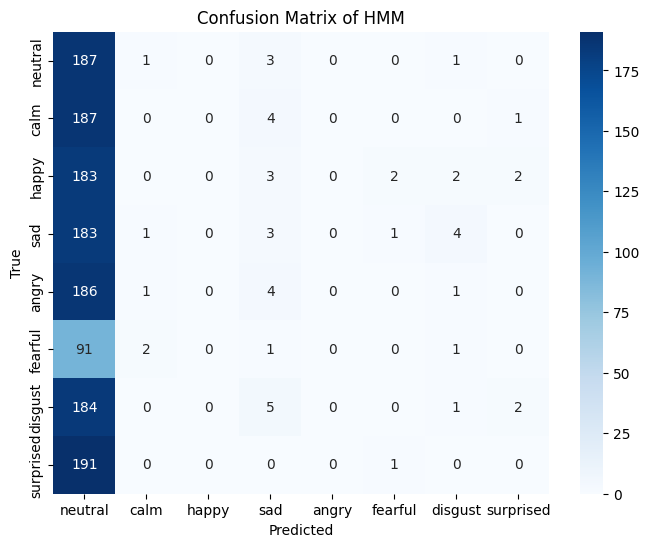

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the emotion labels for display
emotion_labels = list(emotions.values())

# Create a confusion matrix heatmap
plt.figure(figsize=(8,6))
sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=emotion_labels, yticklabels=emotion_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of HMM")
plt.show()


SER Using FNN

In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Path to the RAVDESS dataset
dataset_path = "/content/drive/MyDrive/Speech_Emotion_Detection-master/speech-emotion-recognition-ravdess-data/"

# List of emotions in the RAVDESS dataset
emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Function to extract audio features using Librosa
def extract_features(file_path):
    features = []
    audio, _ = librosa.load(file_path, duration=2.5, offset=0.5)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
    features.extend(np.mean(mfccs.T, axis=0))
    return features

# Load audio files and extract features
X = []
y = []
# Load audio files and extract features
X = []
y = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion = emotions[file.split("-")[2]]
            features = extract_features(file_path)
            X.append(features)
            y.append(emotion)

print(y)  # Print the y array to inspect its content

# Perform label encoding on emotion labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train_fnn, X_test_fnn, y_train_fnn, y_test_fnn = train_test_split(X, y, test_size=0.2, random_state=42)


# Convert the data to NumPy arrays
X_train_fnn = np.array(X_train_fnn)
y_train_fnn = np.array(y_train_fnn)
X_test_fnn = np.array(X_test_fnn)
y_test_fnn = np.array(y_test_fnn)


print("Shape of X_train:", np.array(X_train_fnn).shape)
print("Shape of y_train:", np.array(y_train_fnn).shape)
print("Shape of X_test:", np.array(X_test_fnn).shape)
print("Shape of y_test:", np.array(y_test_fnn).shape)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Determine the number of classes
num_classes = len(np.unique(y_train_fnn))

# Build the model
model_fnn = Sequential()
model_fnn.add(Dense(128, activation='relu', input_shape=(X_train_fnn.shape[1],)))
model_fnn.add(Dropout(0.3))
model_fnn.add(Dense(128, activation='relu'))
model_fnn.add(Dropout(0.3))
model_fnn.add(Dense(num_classes, activation='softmax'))

# Compile and train the model
model_fnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_fnn.fit(X_train_fnn, y_train_fnn, batch_size=32, epochs=10, validation_data=(X_test_fnn, y_test_fnn))

# Evaluate the model
loss, accuracy = model_fnn.evaluate(np.array(X_test_fnn), np.array(y_test_fnn))
print("Test loss:", loss)
print("Test accuracy:", accuracy)

emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

# Predict the emotion for a sample input
sample_file = "/content/drive/MyDrive/Speech_Emotion_Detection-master/output102.wav"
sample_features = extract_features(sample_file)
sample_features = np.array(sample_features).reshape(1, -1)
predicted_emotion = emotions[np.argmax(model_fnn.predict(sample_features))]
print("Predicted emotion:", predicted_emotion)


['neutral', 'neutral', 'happy', 'angry', 'fearful', 'happy', 'calm', 'calm', 'happy', 'angry', 'fearful', 'calm', 'disgust', 'neutral', 'fearful', 'happy', 'sad', 'disgust', 'sad', 'disgust', 'sad', 'fearful', 'calm', 'disgust', 'fearful', 'sad', 'fearful', 'neutral', 'angry', 'disgust', 'disgust', 'sad', 'angry', 'disgust', 'happy', 'fearful', 'happy', 'calm', 'angry', 'calm', 'happy', 'calm', 'angry', 'sad', 'sad', 'angry', 'disgust', 'fearful', 'sad', 'happy', 'calm', 'angry', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'surprised', 'disgust', 'disgust', 'sad', 'happy', 'fearful', 'fearful', 'happy', 'angry', 'happy', 'fearful', 'sad', 'disgust', 'calm', 'calm', 'calm', 'sad', 'disgust', 'fearful', 'disgust', 'angry', 'calm', 'calm', 'neutral', 'disgust', 'happy', 'sad', 'angry', 'happy', 'fearful', 'angry', 'angry', 'neutral', 'neutral', 'calm', 'calm', 'calm', 'sad', 'fearful', 'sad', 'sad', 'angry', 'angry', 'fearful', 'angry', 'disg

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict the emotions for the testing data
y_pred_fnn = np.argmax(model_fnn.predict(X_test_fnn), axis=1)

# Reverse label encoding for 'y_true' and 'y_pred'
y_true_fnn = label_encoder.inverse_transform(y_test_fnn)
y_pred_fnn = label_encoder.inverse_transform(y_pred_fnn)

# Calculate metrics
accuracy = accuracy_score(y_true_fnn, y_pred_fnn)
precision = precision_score(y_true_fnn, y_pred_fnn, average='weighted')
recall = recall_score(y_true_fnn, y_pred_fnn, average='weighted')
f1 = f1_score(y_true_fnn, y_pred_fnn, average='weighted')
print("Metrics of FNN")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the emotions for the testing data
y_pred_fnn_probs = model_fnn.predict(X_test_fnn)
y_pred_fnn = np.argmax(y_pred_fnn_probs, axis=1)
# Convert emotions dictionary to a list
emotions = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]

# Reverse label encoding for 'y_test_fnn' and 'y_pred_fnn'
y_test_fnn_labels = label_encoder.inverse_transform(y_test_fnn)
y_pred_fnn_labels = label_encoder.inverse_transform(y_pred_fnn)

# Calculate confusion matrix
cm_fnn = confusion_matrix(y_test_fnn_labels, y_pred_fnn_labels, labels=emotions)

# Define labels for the confusion matrix
cm_labels = emotions

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_fnn, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
plt.title("Confusion Matrix of FNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


SER Using RNN-LSTM

In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

# Path to the RAVDESS dataset
dataset_path = "/content/drive/MyDrive/Speech_Emotion_Detection-master/speech-emotion-recognition-ravdess-data/"

# List of emotions in the RAVDESS dataset
emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Function to extract audio features using Librosa
def extract_features(file_path):
    features = []
    audio, _ = librosa.load(file_path, duration=2.5, offset=0.5)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
    features.extend(np.mean(mfccs.T, axis=0))
    return features

# Load audio files and extract features
X = []
y = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion = emotions[file.split("-")[2]]
            features = extract_features(file_path)
            X.append(features)
            y.append(emotion)

# Perform label encoding on emotion labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to NumPy arrays
X_train_rnn = np.array(X_train_rnn)
y_train_rnn = np.array(y_train_rnn)
X_test_rnn = np.array(X_test_rnn)
y_test_rnn = np.array(y_test_rnn)

# Determine the number of classes
num_classes = len(np.unique(y_train_rnn))

# Build the RNN model
model_rnn = Sequential()
model_rnn.add(LSTM(128, input_shape=(X_train_rnn.shape[1], 1)))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(num_classes, activation='softmax'))

# Compile and train the model
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_rnn.fit(np.expand_dims(X_train_rnn, axis=2), y_train_rnn, batch_size=32, epochs=10, validation_data=(np.expand_dims(X_test_rnn, axis=2), y_test_rnn))

# Evaluate the model
loss, accuracy = model_rnn.evaluate(np.expand_dims(X_test_rnn, axis=2), y_test_rnn)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

# Reverse label encoding for prediction
inverse_mapping = {v: k for k, v in emotions.items()}

# Predict the emotion for a sample input
sample_file = "/content/drive/MyDrive/Speech_Emotion_Detection-master/output102.wav"
sample_features = extract_features(sample_file)
sample_features = np.array(sample_features).reshape(1, -1)
predicted_emotion_index = np.argmax(model_rnn.predict(np.expand_dims(sample_features, axis=2)))
predicted_emotion_label = emotions.get("{:02d}".format(predicted_emotion_index + 1), "Unknown")
print("Predicted emotion:", predicted_emotion_label)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict the emotions for the testing data
y_pred_rnn = np.argmax(model_rnn.predict(np.expand_dims(X_test_rnn, axis=2)), axis=1)

# Reverse label encoding for 'y_true' and 'y_pred'
y_true_rnn = label_encoder.inverse_transform(y_test_rnn)
y_pred_rnn = label_encoder.inverse_transform(y_pred_rnn)

# Calculate metrics
accuracy = accuracy_score(y_true_rnn, y_pred_rnn)
precision = precision_score(y_true_rnn, y_pred_rnn, average='weighted')
recall = recall_score(y_true_rnn, y_pred_rnn, average='weighted')
f1 = f1_score(y_true_rnn, y_pred_rnn, average='weighted')

print("Metrics of RNN")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

emotions = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgust",
    7: "surprised"
}


# Predict the emotions for the testing data
y_pred_rnn = np.argmax(model_rnn.predict(np.expand_dims(X_test_rnn, axis=2)), axis=1)

# Reverse label encoding for 'y_test_rnn' and 'y_pred_rnn'
y_test_rnn_decoded = label_encoder.inverse_transform(y_test_rnn)
y_pred_rnn_decoded = label_encoder.inverse_transform(y_pred_rnn)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_rnn_decoded, y_pred_rnn_decoded)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(emotions.values()), yticklabels=list(emotions.values()))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of LSTM")
plt.show()



SER Using CNN

In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten

# Path to the RAVDESS dataset
dataset_path = "/content/drive/MyDrive/Speech_Emotion_Detection-master/speech-emotion-recognition-ravdess-data/"

# List of emotions in the RAVDESS dataset
emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# Function to extract audio features using Librosa
def extract_features(file_path):
    features = []
    audio, _ = librosa.load(file_path, duration=2.5, offset=0.5)
    mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
    features.append(mfccs.T)
    return features

# Load audio files and extract features
X = []
y = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion = emotions[file.split("-")[2]]
            features = extract_features(file_path)
            X.extend(features)
            y.extend([emotion] * len(features))

# Perform label encoding on emotion labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Determine the number of classes
num_classes = len(np.unique(y_train_cnn))

# Pad or truncate the feature arrays to a fixed length
max_len = max(len(features) for features in X_train_cnn)
X_train_cnn = [np.pad(features, ((0, max_len - len(features)), (0, 0))) for features in X_train_cnn]
X_test_cnn = [np.pad(features, ((0, max_len - len(features)), (0, 0))) for features in X_test_cnn]

# Convert the data to NumPy arrays
X_train_cnn = np.array(X_train_cnn)
y_train_cnn = np.array(y_train_cnn)
X_test_cnn = np.array(X_test_cnn)
y_test_cnn = np.array(y_test_cnn)

# Build the CNN model
model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1)))
model_cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model_cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax'))

# Compile and train the model
model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.fit(np.expand_dims(X_train_cnn, axis=3), y_train_cnn, batch_size=32, epochs=10, validation_data=(np.expand_dims(X_test_cnn, axis=3), y_test_cnn))

# Evaluate the model
loss, accuracy = model_cnn.evaluate(np.expand_dims(X_test_cnn, axis=3), y_test_cnn)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

# Reverse label encoding for prediction
inverse_mapping = {v: k for k, v in emotions.items()}

# Predict the emotion for a sample input
sample_file = "/content/drive/MyDrive/Speech_Emotion_Detection-master/output102.wav"
sample_features = extract_features(sample_file)
sample_features = [np.pad(features, ((0, max_len - len(features)), (0, 0))) for features in sample_features]
sample_features = np.array(sample_features)
predicted_emotion_index = np.argmax(model_cnn.predict(np.expand_dims(sample_features, axis=3)))
predicted_emotion_label = emotions.get("{:02d}".format(predicted_emotion_index + 1), "Unknown")
print("Predicted emotion:", predicted_emotion_label)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict the emotions for the testing data
y_pred_prob = model_cnn.predict(np.expand_dims(X_test_cnn, axis=3))
y_pred_cnn = np.argmax(y_pred_prob, axis=1)

# Reverse label encoding for 'y_true' and 'y_pred'
y_true_cnn = label_encoder.inverse_transform(y_test_cnn)
y_pred_cnn = label_encoder.inverse_transform(y_pred_cnn)

# Calculate metrics
accuracy = accuracy_score(y_true_cnn, y_pred_cnn)
precision = precision_score(y_true_cnn, y_pred_cnn, average='weighted')
recall = recall_score(y_true_cnn, y_pred_cnn, average='weighted')
f1 = f1_score(y_true_cnn, y_pred_cnn, average='weighted')


print("Metrics of CNN")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ... (previous code up to model evaluation)
# Predict the emotions for the testing data
y_pred_probabilities = model_cnn.predict(np.expand_dims(X_test_cnn, axis=3))
y_pred_cnn = np.argmax(y_pred_probabilities, axis=1)

# Reverse label encoding for 'y_true' and 'y_pred'
y_true_cnn = label_encoder.inverse_transform(y_test_cnn)
y_pred_cnn = label_encoder.inverse_transform(y_pred_cnn)


# Perform label encoding on emotion labels
label_encoder = LabelEncoder()
y_true_numeric = label_encoder.fit_transform(y_true_cnn)
y_pred_numeric = label_encoder.transform(y_pred_cnn)

# Calculate confusion matrix
cm = confusion_matrix(y_true_numeric, y_pred_numeric)

# Define labels for the confusion matrix
cm_labels = label_encoder.classes_


# Define labels for the confusion matrix
labels = list(emotions.values())

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix of CNN")
plt.show()


In [ ]:
import pandas as pd

# Define the models and their corresponding metrics
models = ['CNN', 'LSTM', 'MLP Classifier', 'SVM', 'HMM', 'FNN']
accuracy = [0.53, 0.27, 0.61, 0.54, 0.0, 0.12]
precision = [0.65, 0.42, 0.58, 0.62, 0.0, 0.29]
recall = [0.52, 0.38, 0.63, 0.56, 0.0, 0.19]
f1_score = [0.57, 0.29, 0.60, 0.58, 0.0, 0.22]

# Create a dictionary with the data
data = {
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-score': f1_score
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the Model column as the index
df.set_index('Model', inplace=True)

# Display the DataFrame
print(df)
